In [325]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import heapq
import itertools
import copy
import os
import seaborn as sns
import pandas as pd
import cv2
from PIL import Image
import dataset_64
import time

In [326]:
pretrained_model = "alphabet_model64.pth" #事前学習済みMNISTモデル(重みパラメータ)
use_cuda = True

In [327]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, 26)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# MNISTのTest datasetと dataloaderの定義
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.5,), (0.5,))
#             ])), 
#         batch_size=1, shuffle=False)

# 使うデバイス（CPUかGPUか）の定義
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# ネットワークの初期化
model = Net().to(device)
print(model)
# 訓練済みモデルのロード
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))


# モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
model.eval()

CUDA Available:  True
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)

In [328]:
def im_is_black(image):
    if image < torch.Tensor([0]).to("cuda"):
        return True
    else:
        return False

In [329]:
def im_is_white(image):
    if image >= torch.Tensor([0]).to("cuda"):
        return True
    else:
        return False

In [330]:
def character_search(image):
    image_copy = copy.deepcopy(image)
    for x in range(64):
        for y in range(64):
            if im_is_black(image[x][y]):
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        if (x + i != -1) and (x + i != 64) and (y + j != -1) and (y + j != 64):
                            if im_is_white(image[x + i][y + j]):
                                image_copy[x][y] = torch.Tensor([1]).to("cuda")
                                break
                    else:
                        continue
                    break
                else:
                    image_copy[x][y] = torch.Tensor([0]).to("cuda")
            elif im_is_white(image[x][y]):
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        if (x + i != -1) and (x + i != 64) and (y + j != -1) and (y + j != 64):
                            if im_is_black(image[x + i][y + j]):
                                image_copy[x][y] = torch.Tensor([1]).to("cuda")
                                break
                    else:
                        continue
                    break
                else:
                    image_copy[x][y] = torch.Tensor([0]).to("cuda")
    image_chain = list(itertools.chain.from_iterable(image_copy))
    return image_chain

In [331]:
def attack(image, image_copy, data_grad, max_index_list, target, loss_old):
    stop = 0
    data_grad_chain = list(itertools.chain.from_iterable(data_grad[0][0]))
    character_coordinate = character_search(image_copy.data[0][0])
    for i in range(4096):
        if character_coordinate[i] == torch.Tensor([0]).to("cuda"):
            data_grad_chain[i] = torch.Tensor([0]).to("cuda")
    for j in max_index_list:
        data_grad_chain[j] = torch.Tensor([0]).to("cuda")
    grad_sorted = sorted(list(map(abs, data_grad_chain)), reverse=True)
    data_grad_chain_abs = list(map(abs, data_grad_chain))
    image.requires_grad = False
    cnt = 0
    for k in grad_sorted:
        cnt += 1
        grad_max_index = data_grad_chain_abs.index(k)
        
        if (data_grad_chain[grad_max_index] > 0 and image[0][0][grad_max_index // 64][grad_max_index - 64 * (grad_max_index // 64)] < 0) or (data_grad_chain[grad_max_index] < 0 and image[0][0][grad_max_index // 64][grad_max_index - 64 * (grad_max_index // 64)] > 0):
            image[0][0][grad_max_index // 64][grad_max_index - 64 * (grad_max_index // 64)] *= -1
            output = model(image)
            if F.nll_loss(output, target) < loss_old:
                image[0][0][grad_max_index // 64][grad_max_index - 64 * (grad_max_index // 64)] *= -1
                continue
            # image[0][0][grad_max_index // 64][grad_max_index - 64 * (grad_max_index // 64)] += ((image[0][0][grad_max_index // 64][grad_max_index - 64 * (grad_max_index // 64)] == torch.Tensor([-1]).to("cuda")) * 0.2 - torch.Tensor([0.1]).to("cuda")).squeeze(0)
            else:
                max_index_list.append(grad_max_index)
                break
    else:
        stop = 1
    return image, max_index_list, stop, output

In [332]:
def test( model, device):
    dir = "test"
    chr_lambda = lambda a: chr(a + 65)
    # dirname_grad = "../PGD_alphabet_" + dir + "/grad/"
    # dirname_org = "../PGD_alphabet_" + dir + "/org/"
    # dirname_adv = "../PGD_alphabet_" + dir + "/adv/"
    dirname_grad = "../PGD_alphabet_" + dir + "/grad/"
    dirname_org = "../PGD_alphabet_" + dir + "/org/"
    dirname_adv = "../PGD_alphabet_" + dir + "/adv/"
    dirname_pro = "../PGD_alphabet_" + dir + "/progress/"
    # dirname_grad = "../PGD_alphabet_" + dir + "_upd" + "/grad/"
    # dirname_org = "../PGD_alphabet_" + dir + "_upd" + "/org/"
    # dirname_adv = "../PGD_alphabet_" + dir + "_upd" + "/adv/"
    # dirname_pro = "../PGD_alphabet_" + dir + "_upd" + "/progress/"
    for c in [chr(i) for i in range(65, 65+26)]:
        os.makedirs(dirname_grad + c, exist_ok=True)
        os.makedirs(dirname_org + c, exist_ok=True)
        os.makedirs(dirname_adv + c, exist_ok=True)
        os.makedirs(dirname_pro + c, exist_ok=True)
        for d in [chr(i) for i in range(65, 65+26)]:
            os.makedirs(dirname_adv + c + "/" + c + "→" + d, exist_ok=True)
        for e in range(1, 401):
            os.makedirs(dirname_pro + c + "/{}".format(e), exist_ok=True)
    
    datas = torch.from_numpy(dataset_64.X_test.astype(np.float32)).clone()
    labels = torch.from_numpy(dataset_64.y_test.astype(np.float32)).clone()

    # 精度カウンター
    correct = 0
    # count = 0
    count_list = [0] * 26

    adv_examples = []
    # i=0
    

    # テスト用データセット内の全てのサンプルをループします
    for data, target in zip(datas, labels):
        
        # i+=1
        # if i==150:
        #     break
        # データとラベルをデバイス（CPUもしくはGPU）に送信します
        data, target = data.to(device), target.type(torch.LongTensor).to(device)
        # テンソルの requires_grad 属性を設定します。攻撃者にとっては重要な設定です。
        data.requires_grad = True

        # データをモデルに順伝播させます
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 最大の確率のインデックスを取得します。

        # 最初から予測が間違っている場合、攻撃する必要がないため次のイテレーションに進みます。
        
        if init_pred.item() != target.item() or init_pred.item() != 1:
            continue

        data_copy = data.detach().clone()
        # character_coordinate = character_search(data_copy.data[0][0])
        
        count_list[init_pred.item()] += 1
        
        for px in range(1, 4097):
            data.requires_grad = True
            # 損失を計算します
            loss = F.nll_loss(output, target)
            print("loss:{}".format(loss))
            # 既存の勾配を全てゼロにします
            model.zero_grad()
            # 逆伝播させてモデルの勾配を計算します
            loss.backward()
            # データの勾配を取得します
            data_grad = data.grad.data
            if px == 1:
                max_index = []
                #勾配のヒートマップ
                grad_map = data_grad.squeeze().detach().cpu().numpy()
                grad_map_abs = np.abs(grad_map)
                plt.xticks([], [])
                plt.yticks([], [])
                plt.imsave(dirname_grad + chr_lambda(init_pred.item()) + "/{}.png".format(count_list[init_pred.item()]), grad_map_abs, cmap="Reds")
                # img = cv2.imread(dirname_pro + "A/2/1428.png", cv2.IMREAD_GRAYSCALE)
                # img = (img >= 127) * 2 - 1
                # img_tensor = torch.from_numpy(img.astype(np.float32)).to(device)
                # img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)
                # img_tensor.requires_grad  =True
                # output2 = model(img_tensor)
                # loss = F.nll_loss(output2, target)
                # model.zero_grad()
                # loss.backward()
                # print(img_tensor.shape)
                # data_grad2 = img_tensor.grad.data
                
                # grad_map = data_grad2.squeeze().detach().cpu().numpy()
                # grad_map_abs = np.abs(grad_map)
                # print(grad_map_abs)
                # plt.xticks([], [])
                # plt.yticks([], [])
                # plt.imsave(dirname_grad + chr_lambda(init_pred.item()) + "/after_grad.png", grad_map_abs, cmap="Reds")
                # break

            perturbed_data, max_index, stop, output = attack(data, data_copy, data_grad, max_index, target, loss)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.imsave(dirname_pro + chr_lambda(init_pred.item()) + "/{}".format(count_list[init_pred.item()]) + "/" + "{}.png".format(px), perturbed_data.squeeze().detach().cpu().numpy(), cmap="gray")
            print("px:{}".format(px))
            # output = model(perturbed_data)
            pred = output.max(1, keepdim=True)[1]
            data = perturbed_data
            # plt.xticks([], [])
            # plt.yticks([], [])
            # plt.imsave(dirname_adv + "{}/{}_{}.png".format(init_pred.item(), count_list[init_pred.item()], px), data.squeeze().detach().cpu().numpy(), cmap="gray")
        
            
            
            #勾配の絶対値のグラフ
            # sns.set()
            # sns.set_style('whitegrid')
            # sns.set_palette('gray')
            # data_grad = data_grad.cpu()
            # data_grad = list(list(map(abs, itertools.chain.from_iterable(data_grad[0][0]))))
            # data_grad.sort(reverse=True)
            # x = np.array(list(range(1, 785)))
            # y = np.array(data_grad)
            # fig = plt.figure()
            # ax = fig.subplots()
            # ax.plot(x, y)
            # ax.set_xlabel('absolute gradient rank')
            # ax.set_ylabel('absolute gradient')
            # fig.savefig(dirname_grad + "{}/graph{}.png".format(init_pred.item(), count_list[init_pred.item()]))
            if pred.item() != target.item():
                break
            elif stop == 1:
                break
        
        final_pred = pred

        org = data_copy.squeeze().detach().cpu().numpy()
        adv = perturbed_data.squeeze().detach().cpu().numpy()
        

        #各条件を満たす画像の保存
        plt.xticks([], [])
        plt.yticks([], [])
        print(dirname_org + chr_lambda(init_pred.item()) + "/{}.png".format(count_list[init_pred.item()]))
        plt.imsave(dirname_org + chr_lambda(init_pred.item()) + "/{}.png".format(count_list[init_pred.item()]), org, cmap="gray")
        
        os.makedirs(dirname_adv + chr_lambda(init_pred.item()) + "/" + chr_lambda(init_pred.item()) + "→" + chr_lambda(final_pred.item()) + "/", exist_ok=True)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imsave(dirname_adv + chr_lambda(init_pred.item()) + "/" + chr_lambda(init_pred.item()) + "→" + chr_lambda(final_pred.item()) + "/{}.png".format(count_list[init_pred.item()]), adv, cmap="gray")


        if (final_pred.item() != target.item()):
            # あとで可視化するために敵対的サンプルのうちいくつかを保存
            if len(adv_examples) < 25:
                adv_examples.append( (init_pred.item(), final_pred.item(), org, adv))
                # if len(adv_examples) == 25:
                #     break


        # # epsilonごとの最終的な精度を算出
        # final_acc = correct/float(len(test_loader))
        # print("Test Accuracy = {} / {} = {}".format(correct, len(test_loader), final_acc))

        # # 精度と敵対的サンプルを返却
        # return final_acc, adv_examples

loss:3.576278118089249e-07
px:1
loss:4.768370445162873e-07
px:2
loss:4.887569048150908e-06
px:3
loss:5.483612312673358e-06
px:4
loss:7.033323527139146e-06
px:5
loss:1.7762025890988298e-05
px:6
loss:2.169585604860913e-05
px:7
loss:2.8371408916427754e-05
px:8
loss:3.373566141817719e-05
px:9
loss:4.708655978902243e-05
px:10
loss:6.09140915912576e-05
px:11
loss:6.532455881824717e-05
px:12
loss:8.296622399939224e-05
px:13
loss:8.725739462533966e-05
px:14
loss:0.00013839241000823677
px:15
loss:0.00017975145601667464
px:16
loss:0.00019202772818971425
px:17
loss:0.0002053765201708302
px:18
loss:0.00027450130437500775
px:19
loss:0.00031883400515653193
px:20
loss:0.00032669928623363376
px:21
loss:0.00034957972820848227
px:22
loss:0.0005031750188209116
px:23
loss:0.0005995621904730797
px:24
loss:0.0008631794480606914
px:25
loss:0.0010209829779341817
px:26
loss:0.001065401709638536
px:27
loss:0.0011749514378607273
px:28
loss:0.001484959851950407
px:29
loss:0.0018468719208613038
px:30
loss:0.001948

KeyboardInterrupt: 

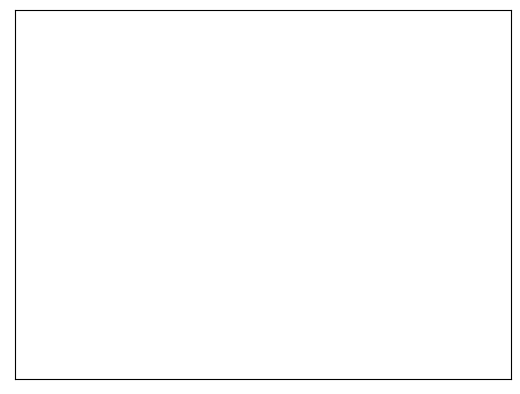

In [333]:
accuracies = []
examples = []

# 各epsilonごとにテストを実行
acc, ex = test(model, device)
accuracies.append(acc)
examples.append(ex)

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))

for j in range(len(examples[0])):
    cnt += 1
    plt.subplot(5,5,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    orig,adv, org_ex, adv_ex = examples[0][j]
    plt.title("{}".format(orig), color="white")
    plt.imshow(org_ex, cmap="gray")
plt.tight_layout()
plt.show()

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))

for j in range(len(examples[0])):
    cnt += 1
    plt.subplot(5,5,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, org_ex, adv_ex = examples[0][j]
    plt.title("{} -> {}".format(orig, adv), color="white")
    plt.imshow(adv_ex, cmap="gray")
plt.tight_layout()
plt.show()